<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/2d_image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D image regression with sparse bvals


In [ ]:
!pip install -q livelossplot

In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.experimental import optimizers, stax

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os

import imageio

from tqdm.notebook import tqdm as tqdm
import numpy as onp

## Random seed
rand_key = random.PRNGKey(10)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


# Load Datasets

Dataset div2k


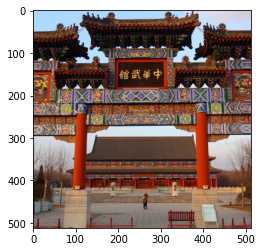

Dataset text


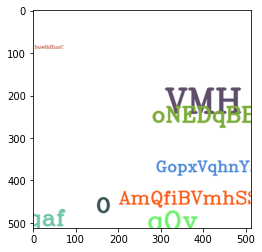

In [ ]:
visualize = True #@param {type:"boolean"}

load_div2k = True #@param {type:"boolean"}
load_text = True #@param {type:"boolean"}

RES = 512

def load_dataset(filename, id):
    if not os.path.exists(filename):
        !gdown --id $id

    npz_data = np.load(filename)
    out = {
        "data_grid_search":npz_data['train_data'] / 255.,
        "data_test":npz_data['test_data'] / 255.,
    }
    return out

datasets = {}
if load_div2k:
    datasets['div2k'] = load_dataset('data_div2k.npz', '1TtwlEDArhOMoH18aUyjIMSZ3WODFmUab')
if load_text:
    datasets['text'] = load_dataset('data_2d_text.npz', '1V-RQJcMuk9GD4JCUn70o7nwQE0hEzHoT')

x1 = np.linspace(0, 1, RES//2+1)[:-1]
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)

x1_t = np.linspace(0, 1, RES+1)[:-1]
x_test = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)

def plot_dataset(dataset):
    plt.imshow(dataset['data_test'][0,:,:,:])
    plt.show()

if visualize:
    for dataset in datasets:
        print(f'Dataset {dataset}')
        plot_dataset(datasets[dataset])

# Setup Training

In [ ]:
def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(3))
  layers.append(stax.Sigmoid)
  return stax.serial(*layers)

model_loss = jit(lambda params, x, y: .5 * np.mean((apply_fn(params, x) - y) ** 2))
model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

input_encoder = jit(lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                    a * np.cos((2.*np.pi*x) @ b.T)], axis=-1))

def train_model(lr, iters, train_data, test_data, name='', plot_groups=None):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    xs = []
    if plot_groups is not None:
        plot_groups['Test PSNR'].append(f'{name}_test')
        plot_groups['Train PSNR'].append(f'{name}_train')
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            xs.append(i)
            if plot_groups is not None:
                plotlosses_model.update({f'{name}_train':train_psnr, f'{name}_test':test_psnr}, current_step=i)
        if i % 100 == 0 and i != 0 and plot_groups is not None:
            plotlosses_model.send()
    if plot_groups is not None:
        plotlosses_model.send()
    results = {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'xs': xs
    }
    return results

# Grid Search bvals for gaussian distribution
The training data used here is different from the data used in the actual task.

In [ ]:
#@markdown ##General Params
#@markdown If `num_images` > 1, live ploting is disabled. If -1 use all images
num_images =  -1#@param
target_distribution = "text" #@param ["div2k", "text"]
#@markdown ##Network Params
network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  2000#@param
#@markdown ##Encoder Params
#@markdown `test_scales` should be a list of scales (things like np.arange(...) are allowed)
test_scales =  [13,14,15]#@param
embedding_size =  256#@param

init_fn, apply_fn = make_network(network_depth, network_width)

bvals = random.normal(rand_key, (embedding_size, 2))
avals = np.ones((bvals.shape[0])) 
print(f'searching over, {test_scales}')

if num_images == 1:
    plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
    plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None
result_psnrs = []
for scale in tqdm(test_scales, leave=False):
    scale_results = []
    data = datasets[target_distribution]['data_grid_search']
    ens_size = num_images if num_images > 0 else data.shape[0]
    for i in tqdm(range(ens_size), desc=f'Scale {scale}', leave=False):
        y_train = data[i,...]
        train_data = (input_encoder(x_train, avals, bvals*scale), y_train[::2,::2,:])
        test_data = (input_encoder(x_test[1::2,1::2], avals, bvals*scale), y_train[1::2,1::2,:])
        scale_results.append(train_model(lr, training_steps, train_data, test_data, name=scale, plot_groups=plt_groups)['test_psnrs'][-1])
    result_psnrs.append(scale_results)

result_psnrs = np.array(result_psnrs)
plt.errorbar(test_scales, np.mean(result_psnrs, axis=-1), yerr=np.std(result_psnrs, axis=-1))
plt.title('Grid search')
plt.xlabel('gaussian scale')
plt.ylabel('PSNR')
plt.show()

best_scale = test_scales[np.argmax(np.mean(result_psnrs, axis=-1))]
print(f'Best gaussian scale for "{target_distribution}" distribuion is {best_scale}')

# Train Model

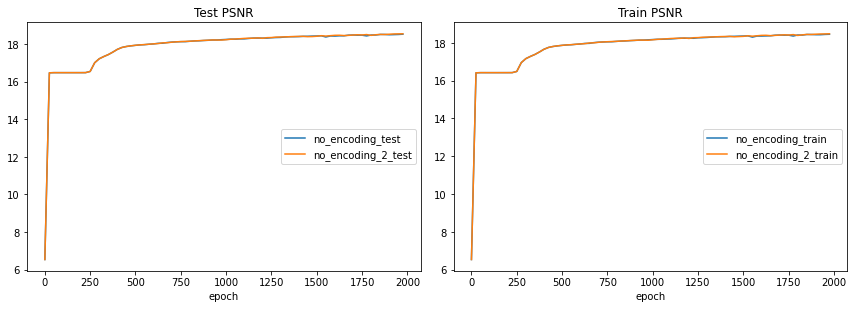

Test PSNR
	no_encoding_test 	 (min:    6.536, max:   18.541, cur:   18.523)
	no_encoding_2_test 	 (min:    6.536, max:   18.550, cur:   18.545)
Train PSNR
	no_encoding_train 	 (min:    6.533, max:   18.480, cur:   18.456)
	no_encoding_2_train 	 (min:    6.533, max:   18.487, cur:   18.481)


In [ ]:
#@markdown ##General Params
#@markdown If ensemble_size > 1, live plots are not rendered.
ensemble_size =  1#@param
target_distribution = "text" #@param ["div2k", "text"]
reset_plots = False #@param {type:"boolean"}

#@markdown ##Network Params
network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  2000#@param

#@markdown ##Encoding Params
embedding_size =  256#@param
posenc_scale =  6#@param
#@markdown gaussian_scales should be a list of scales (things like np.arange(...) allowed)
gaussian_scales = [18] #@param
#@markdown
include_no_encoding = True #@param {type:"boolean"}
include_basic = True #@param {type:"boolean"}
include_new_posenc = True #@param {type:"boolean"}
include_gaussian = True #@param {type:"boolean"}

init_fn, apply_fn = make_network(network_depth, network_width)

if ensemble_size == 1:
    if reset_plots:
        plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
        plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None

if reset_plots:
    enc_dict = {}
    outputs = {}

if include_basic:
    bvals = np.eye(2)
    avals = np.ones((bvals.shape[0])) 
    enc_dict['basic'] = (avals, bvals)

if include_new_posenc:
    bvals = 2.**np.linspace(0,posenc_scale,embedding_size//2) - 1
    bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
    bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
    avals = np.ones((bvals.shape[0])) 
    enc_dict['posenc_new'] = (avals, bvals)

if include_gaussian:
    bvals = random.normal(rand_key, (embedding_size, 2))
    avals = np.ones((bvals.shape[0]))
    for scale in gaussian_scales:
        enc_dict['gaussian_%.2f' % scale] = (avals, bvals * scale)

if include_no_encoding:
    outputs['no_encoding'] = []
    for i in tqdm(range(ensemble_size), desc='no encoding', leave=False):
        y_test = datasets[target_distribution]['data_test'][i,:,:,:]
        outputs['no_encoding'].append(train_model(lr, training_steps, (x_train, y_test[::2,::2,:]), (x_test, y_test), name='no_encoding_2', plot_groups=plt_groups))

for k in tqdm(enc_dict, leave=False):
    outputs[k] = []
    for i in tqdm(range(ensemble_size), desc=k, leave=False):
        y_test = datasets[target_distribution]['data_test'][i,:,:,:]
        train_data = (input_encoder(x_train, *enc_dict[k]), y_test[::2,::2,:])
        test_data = (input_encoder(x_test, *enc_dict[k]), y_test)
        outputs[k].append(train_model(lr, training_steps, train_data, test_data, name=k, plot_groups=plt_groups))

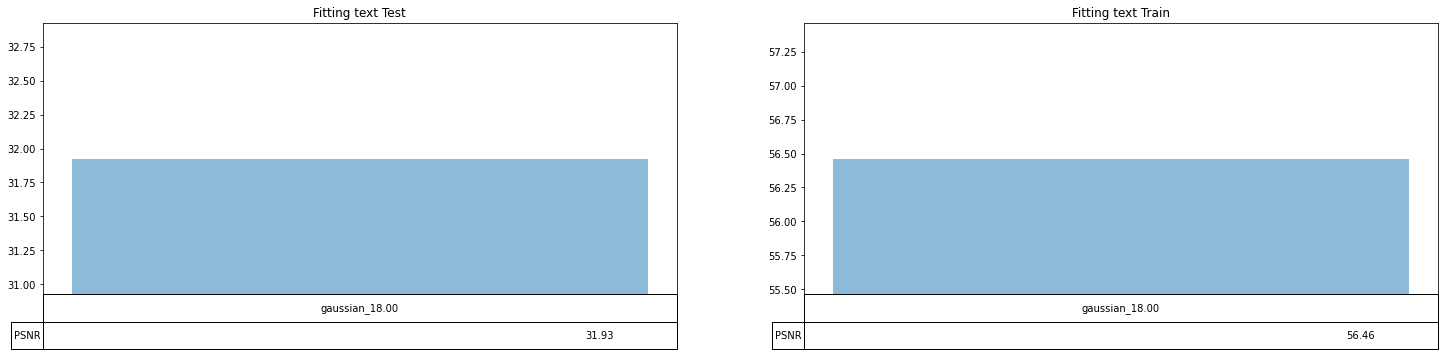

----------------------------------------
                  Test
----------------------------------------


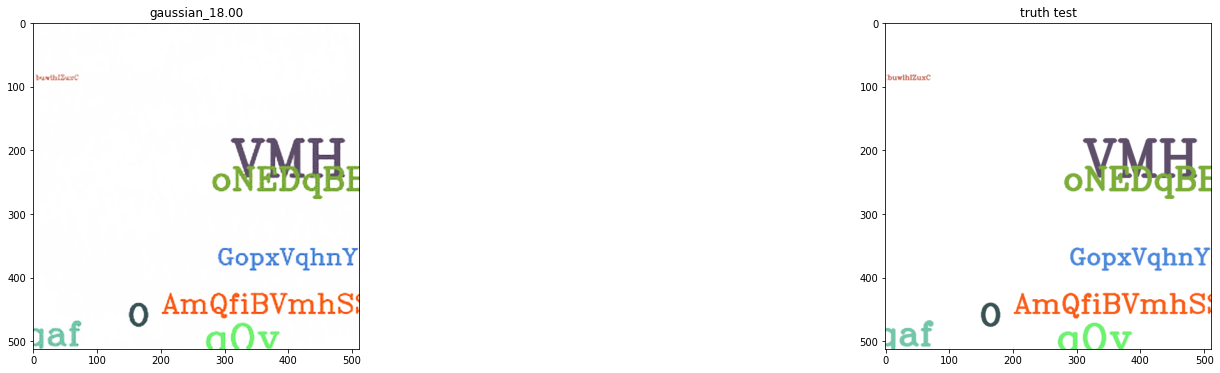

----------------------------------------
                  Train
----------------------------------------


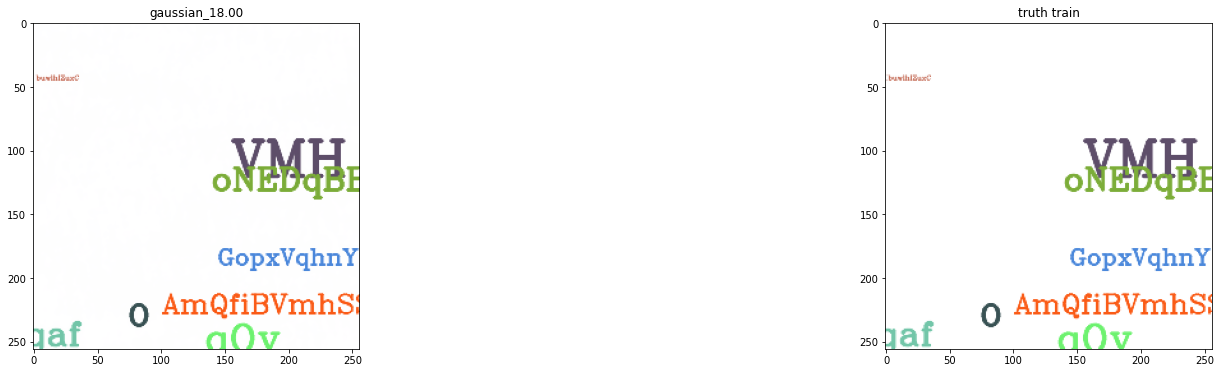

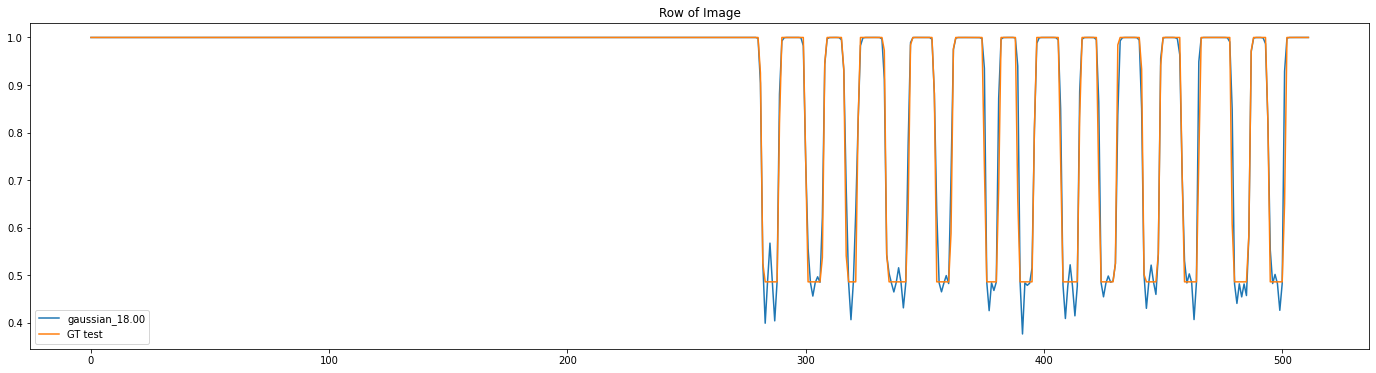

In [ ]:
#@title Plot Results

bar_graph = True #@param {type:"boolean"}
image_reconstructions = True #@param {type:"boolean"}
image_slice = True #@param {type:"boolean"}
test_img_id =  0#@param

names = list(outputs.keys())
y_test = datasets[target_distribution]['data_test'][test_img_id,:,:,:]
xvals = np.arange(len(names))
test_values = np.array([[outputs[n][i]['test_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
test_values_mean = np.mean(test_values, axis=-1)
test_values_std = np.std(test_values, axis=-1)
train_values = np.array([[outputs[n][i]['train_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
train_values_mean = np.mean(train_values, axis=-1)
train_values_std = np.std(train_values, axis=-1)
inds = np.argsort(test_values_mean)
names_sort = [names[i] for i in inds]


if bar_graph:
    plt.figure(figsize=(25,5))
    plt.subplot(1,2,1)
    plt.bar(xvals, test_values_mean[inds], color=colors[0], alpha=.5, yerr=test_values_std)
    # plt.xticks(np.arange(len(names)+2), ['bilinear', 'bicubic'] + names_sort, rotation=60)
    plt.xticks([])
    plt.ylim(test_values_mean.min()-test_values_std.max()-1, test_values_mean.max()+test_values_std.max()+1)
    plt.title(f'Fitting {target_distribution} Test')
    prnt_vals = ['%.2f' % x for x in test_values_mean[inds]]
    plt.table(cellText=[prnt_vals],
        rowLabels=['PSNR'],
        colLabels= names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])

    plt.subplot(1,2,2)
    plt.bar(xvals, train_values_mean[inds], color=colors[0], alpha=.5, yerr=train_values_std)
    # plt.xticks(xvals, names_sort, rotation=60)
    plt.xticks([])
    plt.ylim(train_values_mean.min()-train_values_std.max()-1, train_values_mean.max()+train_values_std.max()+1)
    plt.title(f'Fitting {target_distribution} Train')
    plt.table(cellText=[['%.2f' % x for x in train_values_mean[inds].tolist()]],
        rowLabels=['PSNR'],
        colLabels=names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])
    
    plt.show()

if image_reconstructions:
    print('----------------------------------------')
    print('                  Test')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        if p in enc_dict:
            pred = apply_fn(outputs[p][test_img_id]['state'], input_encoder(x_test, *enc_dict[p]))
        else:
            pred = apply_fn(outputs[p][test_img_id]['state'], x_test)
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(y_test)
    plt.title('truth test')
    plt.show()

    print('----------------------------------------')
    print('                  Train')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        if p in enc_dict:
            pred = apply_fn(outputs[p][test_img_id]['state'], input_encoder(x_train, *enc_dict[p]))
        else:
            pred = apply_fn(outputs[p][test_img_id]['state'], x_train)
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(y_test[::2,::2,:])
    plt.title('truth train')
    plt.show()

if image_slice:
    plt.figure(figsize=(24,6))
    for i, p in enumerate(names_sort):
        if p in enc_dict:
            pred = apply_fn(outputs[p][0]['state'], input_encoder(x_test, *enc_dict[p]))
        else:
            pred = apply_fn(outputs[p][0]['state'], x_test)
        plt.plot(pred[pred.shape[0]//2,:,0], label=p)
    plt.plot(y_test[y_test.shape[0]//2,:,0], label='GT test')
    plt.legend()
    plt.title('Row of Image')
    plt.show()

# Paper Experiments

In [ ]:
rand_key = random.PRNGKey(10)

network_depth = 4
network_width = 256
embedding_size = 256
training_steps =  2000

params = {
    'div2k': {
        'lr': 1e-3,
        'no_enc_lr': 1e-2,
        'basic_lr': 1e-2,
        'posenc_scale': 6,
        'gaussian_scale': 10,
    },
    'text': {
        'lr': 1e-3,
        'no_enc_lr': 1e-3,
        'basic_lr': 1e-3,
        'posenc_scale': 5,
        'gaussian_scale': 14,
    }
}

init_fn, apply_fn = make_network(network_depth, network_width)

gauss_bvals = random.normal(rand_key, (embedding_size, 2))
gauss_avals = np.ones((gauss_bvals.shape[0]))

outputs_final = {}
for target_distribution in tqdm(params):
    enc_dict = {}
    outputs_final[target_distribution] = {}
    dist_params = params[target_distribution]

    bvals = np.eye(2)
    avals = np.ones((bvals.shape[0])) 
    enc_dict['basic'] = (avals, bvals)

    bvals = 2.**np.linspace(0,dist_params['posenc_scale'],embedding_size//2) - 1
    bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
    bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
    avals = np.ones((bvals.shape[0])) 
    enc_dict['posenc_new'] = (avals, bvals)

    enc_dict['gaussian_%.2f' % dist_params['gaussian_scale']] = (gauss_avals, gauss_bvals * dist_params['gaussian_scale'])

    outputs_final[target_distribution]['no_encoding'] = []
    ensemble_size = datasets[target_distribution]['data_test'].shape[0]
    for i in tqdm(range(ensemble_size), desc='no encoding', leave=False):
        y_test = datasets[target_distribution]['data_test'][i,:,:,:]
        outputs_final[target_distribution]['no_encoding'].append(train_model(dist_params['no_enc_lr'], training_steps, (x_train, y_test[::2,::2,:]), (x_test[1::2,1::2], y_test[1::2,1::2,:]), name='no_encoding', plot_groups=None))

    for k in tqdm(enc_dict, desc=target_distribution, leave=False):
        outputs_final[target_distribution][k] = []
        for i in tqdm(range(ensemble_size), desc=k, leave=False):
            y_test = datasets[target_distribution]['data_test'][i,:,:,:]
            train_data = (input_encoder(x_train, *enc_dict[k]), y_test[::2,::2,:])
            test_data = (input_encoder(x_test[1::2,1::2], *enc_dict[k]), y_test[1::2,1::2,:])
            if 'basic' in k:
                lr = dist_params['basic_lr']
            else:
                lr = dist_params['lr']
            outputs_final[target_distribution][k].append(train_model(lr, training_steps, train_data, test_data, name=k, plot_groups=None))

In [ ]:
for ds in outputs_final:
    print(f'-------  Dataset {ds}  -------')
    for k in outputs_final[ds]:
        test_psnr = np.mean(np.array([outputs_final[ds][k][i]['test_psnrs'][-1] for i in range(len(outputs_final[ds][k]))]))
        test_std = np.std(np.array([outputs_final[ds][k][i]['test_psnrs'][-1] for i in range(len(outputs_final[ds][k]))]))
        print(f'    {k}:             %.3f      std: %.3f' % (test_psnr, test_std))

-------  Dataset div2k  -------
    no_encoding:             19.323      std: 2.481
    basic:             21.716      std: 2.717
    posenc_new:             24.947      std: 3.719
    gaussian_10.00:             25.568      std: 4.186
-------  Dataset text  -------
    no_encoding:             18.397      std: 2.340
    basic:             20.478      std: 1.961
    posenc_new:             27.567      std: 3.073
    gaussian_14.00:             30.470      std: 2.108


# Teaser Figure

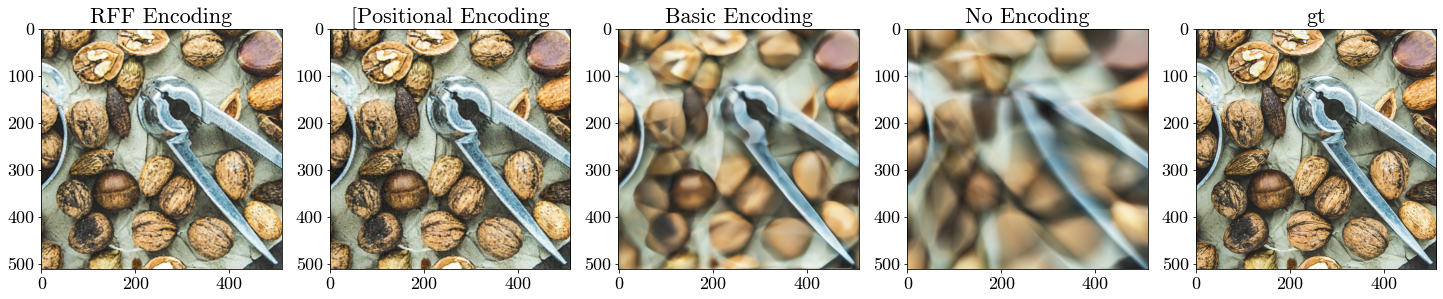

In [ ]:
plt.figure(figsize=(25,8))
test_img_id = 8
plt.subplot(1,5,1)
pred = apply_fn(outputs_final['div2k']['gaussian_10.00'][test_img_id]['state'], input_encoder(x_test, gauss_avals, gauss_bvals * params['div2k']['gaussian_scale']))
imageio.imwrite(f'div2k_{test_img_id}_rff.png', pred)
plt.imshow(pred)
plt.title('RFF Encoding')
plt.subplot(1,5,2)
bvals = 2.**np.linspace(0,params['div2k']['posenc_scale'],embedding_size//2) - 1
bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
avals = np.ones((bvals.shape[0])) 
pred = apply_fn(outputs_final['div2k']['posenc_new'][test_img_id]['state'], input_encoder(x_test, avals, bvals))
imageio.imwrite(f'div2k_{test_img_id}_posenc.png', pred)
plt.imshow(pred)
plt.title('[Positional Encoding')
plt.subplot(1,5,3)
pred = apply_fn(outputs_final['div2k']['basic'][test_img_id]['state'], input_encoder(x_test, *enc_dict['basic']))
imageio.imwrite(f'div2k_{test_img_id}_basic.png', pred)
plt.imshow(pred)
plt.title('Basic Encoding')
plt.subplot(1,5,4)
pred = apply_fn(outputs_final['div2k']['no_encoding'][test_img_id]['state'], x_test)
imageio.imwrite(f'div2k_{test_img_id}_no_enc.png', pred)
plt.imshow(pred)
plt.title('No Encoding')
plt.subplot(1,5,5)
gt_img = datasets['div2k']['data_test'][test_img_id,:,:,:]
imageio.imwrite(f'div2k_{test_img_id}_gt.png', gt_img)
plt.imshow(gt_img)
plt.title('gt')

plt.show()

# Sup Images

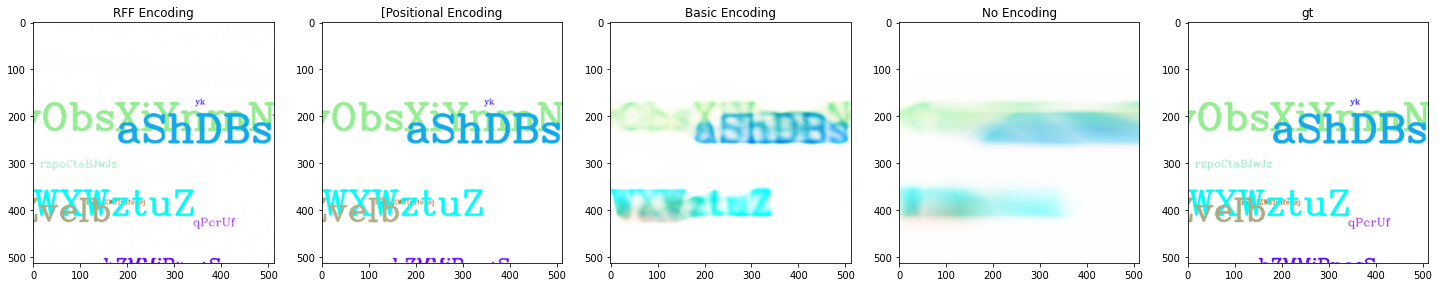

In [ ]:
plt.figure(figsize=(25,8))
test_img_id = 2
plt.subplot(1,5,1)
pred = apply_fn(outputs_final['text']['gaussian_14.00'][test_img_id]['state'], input_encoder(x_test, gauss_avals, gauss_bvals * params['text']['gaussian_scale']))
imageio.imwrite(f'text_{test_img_id}_rff.png', pred)
plt.imshow(pred)
plt.title('RFF Encoding')
plt.subplot(1,5,2)
bvals = 2.**np.linspace(0,params['text']['posenc_scale'],embedding_size//2) - 1
bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
avals = np.ones((bvals.shape[0])) 
pred = apply_fn(outputs_final['text']['posenc_new'][test_img_id]['state'], input_encoder(x_test, avals, bvals))
imageio.imwrite(f'text_{test_img_id}_posenc.png', pred)
plt.imshow(pred)
plt.title('[Positional Encoding')
plt.subplot(1,5,3)
pred = apply_fn(outputs_final['text']['basic'][test_img_id]['state'], input_encoder(x_test, *enc_dict['basic']))
imageio.imwrite(f'text_{test_img_id}_basic.png', pred)
plt.imshow(pred)
plt.title('Basic Encoding')
plt.subplot(1,5,4)
pred = apply_fn(outputs_final['text']['no_encoding'][test_img_id]['state'], x_test)
imageio.imwrite(f'text_{test_img_id}_no_enc.png', pred)
plt.imshow(pred)
plt.title('No Encoding')
plt.subplot(1,5,5)
gt_img = datasets['text']['data_test'][test_img_id,:,:,:]
imageio.imwrite(f'text_{test_img_id}_gt.png', gt_img)
plt.imshow(gt_img)
plt.title('gt')

plt.show()

# Sparse Figure

In [ ]:
#@markdown ##General Params
#@markdown If `num_images` > 1, live ploting is disabled. If -1 use all images
num_images =  -1#@param
target_distribution = "div2k"
network_depths =  [2,4,8]
network_width = 256
lr =  1e-3
training_steps = 2000
#@markdown ##Encoder Params
#@markdown `test_scales` should be a list of scales (things like np.arange(...) are allowed)
embedding_sizes =  [8,16,32,64,128,256,512,1024]#@param
scale = 10

size_results_vis = {}
for depth in network_depths:
    init_fn, apply_fn = make_network(depth, network_width)

    if num_images == 1:
        plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
        plotlosses_model = PlotLosses(groups=plt_groups)
    else:
        plt_groups = None
    result_psnrs = []
    for embedding_size in tqdm(embedding_sizes, leave=False):
        size_results = []
        bvals = random.normal(rand_key, (embedding_size, 2))
        avals = np.ones((bvals.shape[0])) 
        data = datasets[target_distribution]['data_test']
        ens_size = num_images if num_images > 0 else data.shape[0]
        for i in tqdm(range(ens_size), desc=f'Size {embedding_size}', leave=False):
            y_train = data[i,...]
            train_data = (input_encoder(x_train, avals, bvals*scale), y_train[::2,::2,:])
            test_data = (input_encoder(x_test, avals, bvals*scale), y_train)
            size_results.append(train_model(lr, training_steps, train_data, test_data, name=embedding_size, plot_groups=plt_groups)['test_psnrs'][-1])
        result_psnrs.append(size_results)

    result_psnrs = np.array(result_psnrs)
    size_results_vis[depth] = (embedding_sizes, result_psnrs)
    plt.errorbar(embedding_sizes, np.mean(result_psnrs, axis=-1), yerr=np.std(result_psnrs, axis=-1))
    plt.title('Grid search')
    plt.xlabel('Embedding Size')
    plt.ylabel('PSNR')
    plt.show()

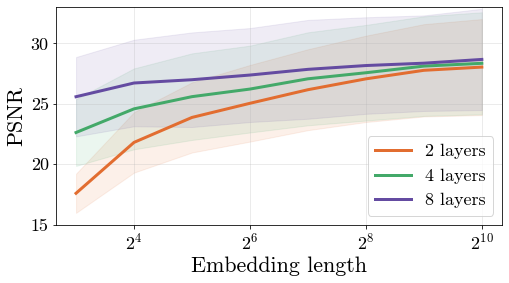

In [ ]:
import matplotlib
import matplotlib.pylab as pylab
params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize': 18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    # [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2

fig = plt.figure(figsize=(8,4))
ax = plt.gca()
for i, key in enumerate(size_results_vis):
    test_sizes, result_psnrs = size_results_vis[key]
    y_mean = np.mean(result_psnrs, axis=-1)
    y_std = np.std(result_psnrs, axis=-1)
    plt.semilogx(np.array(test_sizes), y_mean, c=colors_k[i], label=f'{key} layers', linewidth=3)
    plt.fill_between(test_sizes, y_mean-y_std, y_mean+y_std, color=colors_k[i], alpha=.1)
plt.autoscale(enable=True, axis='y', tight=True)
plt.xscale('log', basex=2)
# ax.set_yticks(ytick)
# ax.set_yticklabels([fr'${t:g}$' for t in ytick])
ax.set_ylim([15,33])
plt.xlabel('Embedding length')
plt.ylabel('PSNR')
plt.legend(loc='lower right')
plt.grid(True, which="both", ls='-', alpha=.3)

plt.savefig('2d_sparse.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

# Varying Scales

In [ ]:
#@markdown ##General Params
test_img =  0#@param
target_distribution = "div2k"

#@markdown ##Network Params
network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  2000#@param

#@markdown ##Encoding Params
embedding_size =  256#@param
#@markdown gaussian_scales should be a list of scales (things like np.arange(...) allowed)
gaussian_scales = [1,2,4,8,10,16,32,64] #@param
#@markdown

init_fn, apply_fn = make_network(network_depth, network_width)

bvals = random.normal(rand_key, (embedding_size, 2))
avals = np.ones((bvals.shape[0]))
enc_dict_vary = {}
for scale in gaussian_scales:
    enc_dict_vary['gaussian_%.2f' % scale] = (avals, bvals * scale)

outputs_vary = {}
for k in tqdm(enc_dict_vary, leave=False):
    y_test = datasets[target_distribution]['data_test'][test_img,:,:,:]
    train_data = (input_encoder(x_train, *enc_dict_vary[k]), y_test[::2,::2,:])
    test_data = (input_encoder(x_test, *enc_dict_vary[k]), y_test)
    outputs_vary[k] = train_model(lr, training_steps, train_data, test_data, name=k, plot_groups=None)

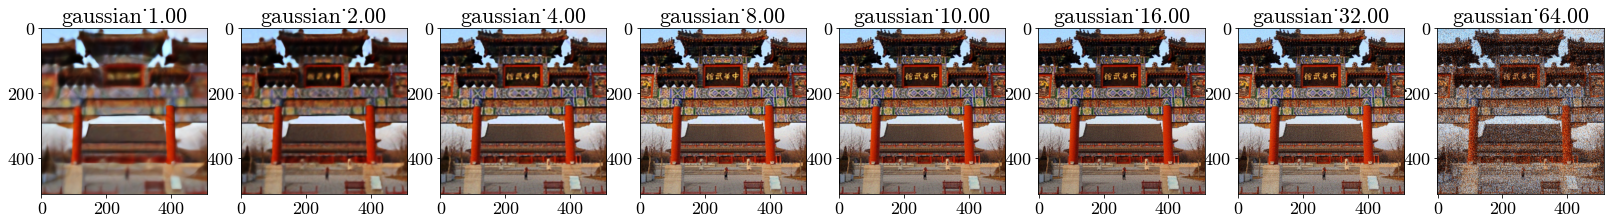

In [ ]:
plt.figure(figsize=(28,6))
for i, p in enumerate(outputs_vary):
    pred = apply_fn(outputs_vary[p]['state'], input_encoder(x_test, *enc_dict_vary[p]))
    plt.subplot(1,len(outputs_vary),i+1)
    imageio.imwrite(f'sweep_{test_img}_{p}.png', pred)
    plt.imshow(pred)
    plt.title(p)